In [36]:
#all imports
import math as m
import numpy as np
import pandas as pd
import copy
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

#shift+enter to run a cell
#trying to implement the third answer on here:https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
#into my Graph class.  By running my gui front end cell you get the error.

In [37]:
#Point and Defect Classes
 

class Points():
    
    def __init__(self, params):
        self.name = params[0]
        self.x = int(params[5])
        self.y = int(params[6])
        self.pos = (self.x,self.y)
        self.x_drift = int(params[3])
        self.y_drift = int(params[4])
        self.group = params[7]
        self.explosion = params[8]
        self.graph = True

        if params[9] == "minimal":     #there is almost no noise
            self.noise = 0
        elif params[9] == "little":    #there is some noise, but not in the areas where I see peaks
            self.noise = 1
        elif params[9] == "a bit":     #there is some noise and could affect the peaks a little
            self.noise = 2
        else:
            self.noise = 3             #there is noise, but barely not enough for me to ignore the results

        self.pot_diff = (float(params[10]),float(params[11]))
        self.peaks = {}

        leftovers = params[12::]
        for i in leftovers:
            if i != '':
                self.peaks[float(i)] = True
        
        #to use later when implementing a data submission form
        #self.x_original = params[1]     
        #self.y_original = params[2]
        #self.x = self.x_original - self.x_drift
        #self.y = self.y_original - self.y_drift

    def __repr__(self):
        return "Point " + self.name + " at position " + str(self.pos) + " with peaks " + str(self.peaks)
    
    def __str__(self):
        return "Point " + self.name
    
    def info(self):
        print( self.name + "\n" + "Position: " + str(self.pos) + '\n' + "Peaks: " + str(self.peaks) + '\n' + "Drift(x,y): " + '(' + str(self.x_drift) +','+ str(self.y_drift) + ')' + "   Noise level: " +str(self.noise) + "\n" + "Potential difference: " + str(self.pot_diff) + '\n' + "Explosion: " + self.explosion + "   Group: " + self.group + '\n' )
        return
    
    def __sub__(self,other):          #for distance between points
        dist_x = self.x - other.x
        dist_y = self.y - other.y
        magnitude = m.sqrt(dist_x**2 + dist_y**2)
        return magnitude
    

class Defect():
    
    def __init__(self,params):
        self.name = params[0]
        self.x = params[1]
        self.y = params[2]
        self.pos = (self.x,self.y)

    def __sub__(self,other):          #for distance between point and the defect, for specific range graphing
        dist_x = self.x - other.x
        dist_y = self.y - other.y
        magnitude = m.sqrt(dist_x**2 + dist_y**2)
        return magnitude
    
    def __repr__(self):
        return self.name
    
    def __str__(self):
        return self.name + " at position " + str(self.pos)


In [38]:
#Graph Class



class Graph():
    
    def __repr__(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def __init__(self,params):
        self.name = params[0]
        self.samples = params[1]
        self.graph_num = 0
        self.refine_list = {'noise':[False],'position':[False],'explode':[False],'peaks':[False]}
        
    def scatter3(self):
        '''Scatter plot of the paramater list'''

        self.graph_num = 1
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plt.title('di/dv Peaks')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        #fig.set_size_inches(11,7)     #18.5, 10.5)
        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()

        x = []
        y = []
        z = []

        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)
        
        X = np.transpose(np.array([x,y,z]))
        ax.scatter(y,x,z,depthshade = False, picker = True)
        fig.canvas.mpl_connect('motion_notify_event', onMouseMotion(_,X,ax))  # on mouse motion
        plt.show()
        return

    def scatter_color(self):
        '''Color scatter plot'''

        self.graph_num = 2
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plt.title('di/dv Peaks')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        fig.set_size_inches(12,7)     #18.5, 10.5)
        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()

        x = []
        y = []
        z = []
        
        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)

        ax.scatter(x,y,z, 'z',c = z, cmap=plt.cm.jet) #spring,viridis,plasma,jet
        plt.show()
        return

    def scatter_angle(self, rotation, elevation):
        '''Scatter plot at different angles, preset in graphing buttons'''
        
        if rotation == 0 and elevation == -90:
            self.graph_num = 3
        if rotation == -90 and elevation == 0:
            self.graph_num = 4
        if rotation == 0 and elevation == 0:
            self.graph_num = 7
            
        fig = plt.figure()
        fig.set_size_inches(16.5,8.5)     #18.5, 10.5)
        ax = fig.add_subplot(111, projection='3d')

        plt.title('di/dv Peaks')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')

        x = []
        y = []
        z = []

        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)
        ax.scatter(y,x,z)

        ax.azim = rotation #0 for x view, -90 for y view
        ax.elev = elevation #-90 for top view

        if rotation == 0:
            plt.title('di/dv Peaks -  x Side View')
        if rotation == -90:
            plt.title('di/dv Peaks -  y Side View')
        if elevation == -90:
            plt.title('di/dv Peaks - Top View')
            fig.set_size_inches(8.5,16.5)

        plt.yticks(np.arange(800,870,10))
        plt.xticks(np.arange(1925,2200,50))
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        plt.show()

        return

    def scatter_color_angle(self, rotation, elevation):
        '''scatter plot at angles with color'''
        if rotation == -90 and elevation == 0:
            self.graph_num = 5
        if rotation == 0 and elevation == -90:
            self.graph_num = 6
        if rotation == 0 and elevation == 0:
            self.graph_num = 8
                        
        fig = plt.figure()
        fig.set_size_inches(16.5,8.5)     #18.5, 10.5)
        ax = fig.add_subplot(111, projection='3d')


        plt.title('di/dv Peaks')
        ax.set_xlabel('y')
        ax.set_ylabel('x')
        ax.set_zlabel('Peak')
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()

        x = []
        y = []
        z = []
        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if point.peaks[peak] == True:
                        x.append(point.x)
                        y.append(point.y)
                        z.append(peak)

        ax.scatter(x,y,z, 'z',c = z, cmap=plt.cm.jet)

        ax.azim = rotation #0 for x view, -90 for y view
        ax.elev = elevation #-90 for top view

        if rotation == 0:
            plt.title('di/dv Peaks -  x Side View')
        if rotation == -90:
            plt.title('di/dv Peaks -  y Side View')
        if elevation == -90:
            plt.title('di/dv Peaks - Top View')
            fig.set_size_inches(8.5,16.5)

        ax.legend(fontsize='small')
        plt.show()

        return
    
    def noise(self,noise):
        for point in self.samples:
            if point.graph == True:
                if point.noise <= noise:
                    point.graph = True
                else:
                    point.graph = False
        return

    def explode(self, explosion):
        for point in self.samples:
            if point.graph == True:
                if point.explosion == explosion:
                    point.graph = True
                else:
                    point.graph = False
        return

    def position(self, min_val, max_val):
        for point in self.samples:
            if point.graph == True:
                if min_val <= point.y <= max_val:
                    point.graph = True
                else:
                    point.graph = False
        return

    def peaks(self,min_peak,max_peak):
        for point in self.samples:
            if point.graph == True:
                for peak in point.peaks:
                    if min_peak < peak < max_peak:
                        peak = True
        return

    def reset(self):
        for point in self.samples:
            point.graph = True
            for peak in point.peaks:
                peak = True
        for ref in self.refine_list:
            self.refine_list[ref] = [False]
        return

    
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import proj3d

def distance(point, axxxx, event):
    """Return distance between mouse position and given data point

    Args:
        point (np.array): np.array of shape (3,), with x,y,z in data coords
        event (MouseEvent): mouse event (which contains mouse position in .x and .xdata)
    Returns:
        distance (np.float64): distance (in screen coords) between mouse pos and data point
    """
    assert point.shape == (3,), "distance: point.shape is wrong: %s, must be (3,)" % point.shape

    # Project 3d data space to 2d data space
    x2, y2, _ = proj3d.proj_transform(point[0], point[1], point[2], plt.gca().get_proj())
    # Convert 2d data space to 2d screen space
    x3, y3 = axxxx.transData.transform((x2, y2))
    print(event)
    return np.sqrt ((x3 - event.x**2 + (y3 - event.y**2)))


def calcClosestDatapoint(te, axxx, event):
    """"Calculate which data point is closest to the mouse position.

    Args:
        X (np.array) - array of points, of shape (numPoints, 3)
        event (MouseEvent) - mouse event (containing mouse position)
    Returns:
        smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
    """
    distances = [distance (te[i, 0:3], axxx, event) for i in range(te.shape[0])]
    return np.argmin(distances)


def annotatePlot(te, index, axxx):
    """Create popover label in 3d chart

    Args:
        X (np.array) - array of points, of shape (numPoints, 3)
        index (int) - index (into points array X) of item which should be printed
    Returns:
        None
    """
    # If we have previously displayed another label, remove it first
    if hasattr(annotatePlot, 'label'):
        annotatePlot.label.remove()
    # Get data point from array of points X, at position index
    x2, y2, _ = proj3d.proj_transform(te[index, 0], te[index, 1], te[index, 2], axxx.get_proj())
    annotatePlot.label = plt.annotate( "Value %d" % index,
        xy = (x2, y2), xytext = (-20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    fig.canvas.draw()


def onMouseMotion(event,te,axx):
    """Event that is triggered when mouse is moved. Shows text annotation over data point closest to mouse."""
    closestIndex = calcClosestDatapoint(te, axx, event)
    annotatePlot (te, closestIndex,axx) 
    
#ex: graph_1 = Graph('graph_1',sample_set)    

In [39]:
#Uploads the curent data file, creates a sample set, and graph class

sample_set = []

with open("Peak_data.csv") as file:
    for line in file:
        data = line.strip().split(',')
        try:
            if data[0][2] == '_':
                sample_set.append(Points(data))
        except:
            IndexError 

analysis = Graph(['analysis',sample_set])

In [40]:
#Alloted for GUI Back end

from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from IPython.display import display
from IPython.display import clear_output
import warnings
#warnings.filterwarnings('ignore')


#functions to call the choice functions because the button widget does not allow for paramater input

def call_function(sender):     #user input function
    user_input = sender.value
    print(user_input)  
    return

def graph1(val):
    clear_output()
    analysis.scatter3()
    return
    
def graph2(val):
    clear_output()
    analysis.scatter_color()
    return

def graph3(val):
    clear_output()
    analysis.scatter_angle(0,-90)
    return

def graph4(val):
    clear_output()
    analysis.scatter_angle(-90,0)
    return

def graph5(val):
    clear_output()
    analysis.scatter_color_angle(-90,0)
    return

def graph6(val):
    clear_output()
    analysis.scatter_color_angle(0,-90)
    return

def graph7(val):
    clear_output()
    analysis.scatter_angle(0,0)
    return

def graph8(val):
    clear_output()
    analysis.scatter_color_angle(0,0)
    return

def refine1(name,new):
    if new == 'minimal':
        temp = 0
    elif new == 'a little':
        temp = 1
    elif new == 'moderate':
        temp = 2
    else:
        temp = 3
    analysis.refine_list['noise'] = [True,temp]
    return    

def refine2(name,new):
    print('hi')
    if new == 'all':
        temp = 'all'
    elif new == 'before':
        temp = 'pre+'
    else:
        temp = 'post'
    analysis.refine_list['explode'] = [True,temp]
    return

def refine3(sender):
    analysis.refine_list['position'] = [True,int(position_filter.value[0]),int(position_filter.value[1])]
    return

def refine4(sender):
    analysis.refine_list['peaks'] = [True,float(peak_range.value[0]),(peak_range.value[1])]
    return

def refine5(val):
    clear_output()
    num = analysis.graph_num

    if analysis.refine_list['noise'][0] == True:
        analysis.noise(analysis.refine_list['noise'][1])
    if analysis.refine_list['explode'][0] == True:
        analysis.explode(analysis.refine_list['explode'][1])
    if analysis.refine_list['position'][0] == True:
        analysis.position(analysis.refine_list['position'][1],analysis.refine_list['position'][2])
    if analysis.refine_list['peaks'][0] == True:
        analysis.peaks(analysis.refine_list['peaks'][1],analysis.refine_list['peaks'][2])
  
    if num == 0:
        return
    elif num == 1:
        analysis.scatter3()
    elif num == 2:
        analysis.scatter_color()
    elif num == 3:
        analysis.scatter_angle(0,-90)
    elif num == 4:
        analysis.scatter_angle(-90,0)
    elif num == 5:
        analysis.scatter_color_angle(-90,0)
    elif num == 6:
        analysis.scatter_color_angle(0,-90)
    elif num == 7:
        analysis.scatter_angle(0,0)
    elif num == 8:
        analysis.scatter_color_angle(0,0)
        
    return

def refine6(val):
    clear_output()
    analysis.reset()
    refine5(5)
    return

#for user input selection process
#text = widgets.Text()
#input_field = widgets.Text()
#display(text)
#input_field.on_submit(call_function)

<IPython.core.display.Javascript object>


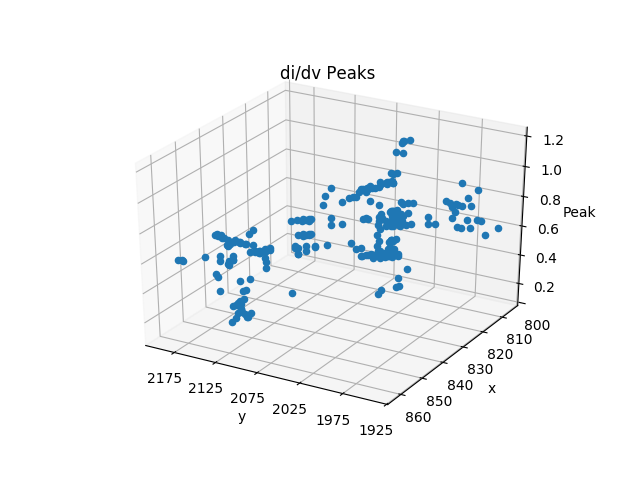

AttributeError: 'str' object has no attribute 'x'

In [41]:
#Alloted for GUI Front End

#Title

#graph buttons
scat3 = widgets.Button(description='Scatter Plot',button_style='info')
scat3c = widgets.Button(description='Color Scatter Plot',button_style='info')
side = widgets.Button(description='Side View',button_style='info')
top = widgets.Button(description='Top View',button_style='info')
sidec = widgets.Button(description='Color Side View',button_style='info')
topc = widgets.Button(description='Color Top View',button_style='info')
sidex = widgets.Button(description='Side View(x)',button_style='info')
sidexc = widgets.Button(description='Color Side View(x)',button_style='info')


#data refinement buttons
apply = widgets.Button(description='Apply Filters',button_style='success')
reset = widgets.Button(description='Reset',button_style='warning')
noise_filter = widgets.Dropdown(options=['all points','moderate','a little','minimal'],description='noise')
pre_post = widgets.Dropdown(options=['all','before','after'],description='Explosion')
position_filter = widgets.IntRangeSlider(value=[800, 2200],min=800,max=2200,step=1,description='Range',continuous_update=True,orientation='horizontal',readout=True,readout_format='i',)
peak_range = widgets.FloatRangeSlider(value=[0, 1.2],min=0,max=1.2,step=.1,description='Peak Range',continuous_update=True,orientation='horizontal',readout=True,readout_format='i',)


#display buttons
display(widgets.HBox((scat3,side,top,sidex)))
display(widgets.HBox((scat3c,sidec,topc,sidexc)))
display(widgets.HBox((noise_filter,pre_post,apply)))
display(widgets.HBox((position_filter,peak_range,reset)))


#button functions
scat3.on_click(graph1)
scat3c.on_click(graph2)
side.on_click(graph4)
top.on_click(graph3)
sidec.on_click(graph5)
topc.on_click(graph6)
sidex.on_click(graph7)
sidexc.on_click(graph8)
reset.on_click(refine6)
apply.on_click(refine5)
noise_filter.on_trait_change(refine1,'value')
pre_post.on_trait_change(refine2,'value')
position_filter.on_trait_change(refine3)
peak_range.on_trait_change(refine4)

#add an apply filter button

In [7]:
#Alloted for data submission

test_samples = []
def final(data_list):
    new_point = Points(data_list)
    test_samples.append(new_point)
    return

end_call = False
while end_call != True:
    print('Create New Point','\n')
    answer = input("Yes/No: ")
    if answer == 'Yes':
        clear_output()
        print('Create New Point','\n')
        df = pd.DataFrame(columns=["Data Point Info"])
        questions = ["Point name: ","X drift: ","Y drift: ","X position: ","Y position: ","Group number: ","pre+ or post tip explosion: ","Noise level: ","Potential min: ","Potential max: "]

        for i in range(10):
            dp = input("{}".format(questions[i]))
            df1 = pd.DataFrame(data=[[dp]],columns=["Data Point Info"])
            df = pd.concat([df,df1], axis=0) #this is like +=

        df.index = range(len(df.index))
        
        peaks = []
        print("Input a Peak value or type 'Quit' to finish: ",'\n')
        answer2 = input("Peak value: ")
        while answer2 != 'Quit':
            peaks.append(answer2)
            answer2 = input("Peak value: ")

        print("Is this information correct? ")
        answer3 = input("Yes/No: ")
        if answer3 == "Yes":
            global data
            data = []
            for j in df.values:
                data.append(j[0])

            final_data = []
            final_data.append(data[0])
            final_data.append('blank')
            final_data.append('blank')
            final_data.append(data[1])
            final_data.append(data[2])
            final_data.append(data[3])
            final_data.append(data[4])
            final_data.append(data[5])
            final_data.append(data[6])
            final_data.append(data[7])
            final_data.append(data[8])
            final_data.append(data[9])
            for k in peaks:
                final_data.append(k)
            final(final_data) 
            
        else:
            clear_output()
            print("Point aborted")
    else:
        clear_output()
        if len(test_samples) > 0:
            print('Points created: ','\n')
            for ii in test_samples:
                print(ii.info())
        else:
            print('End')
        end_call = True

# For use when inputting real data        
#if len(test_samples) > 0:
#    print('Do you wish to add these points to the data set?')
#    answer4 = input('Yes/No: ')
#    if answer4 == 'Yes':
#        for jj in test_samples:
#            samples.append(jj)
#            print('Points added')
#    else:
#        print('Are you sure?')
#        answer5 = input('Yes/No')
#        if answer5 == "Yes":
#            test_samples.clear()
#        else:
#            for jj in test_samples:
#                samples.append(jj)
#                print('Points added')   



End


In [8]:
#Alloted for holding test code

#wireframe basics
#x = []
#y = []
#z = []
#x.append(point.x)
#y.append(point.y)
#z.append(peak)
#fig2 = plt.figure()
#ax2 = fig.add_subplot(111,projection='3d')
#ax2.plot_wireframe(x,y,z)

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

#class testing
#Testing out my imported data
#print("length of samples list: ",len(samples))
#test = samples[33]
#print("print(test) --> ",test)
#print("test.info() --> see below",'\n')
#test.info()
#testing out defect and distance
#defect_1 = Defect(['defect_1',850,2150])
#print("Specify location of possible defect: ",defect_1)
#dist = defect_1 - samples[33]
#print("Find distance between point and the defect: ",dist)

#graph testing
#graph1 = scatter3(sel_samples)          #classic graph
#graph2 = scatter_color(sel_samples)     #colors separated by peak value
#graph3 = scatter_angle(sel_samples,-90)  #above view
#graph4 = scatter_angle(sel_samples,0)    #side view
#graph5 = scatter_color_angle(sel_samples,0)   #color side view

#gui testing
#testing
#print('first graph, sets the graph_num value')
#graph_num = current_graph(2,sel_samples)
#print('first refine, graphs with only minimal noise(noise level 0)')
#sel_samples = refine(1,graph_num,sel_samples,0,0)
#print('second refine, graphs only points before tip explosion')
#sel_samples = refine(2,graph_num,sel_samples,'pre+',0)
#print('reset')
#sel_samples = refine(5,graph_num,samples,0,0)
#print('first refine, graphs only points in the range 2050 and 2025') #weird shape, but works, fix later
#sel_samples = refine(3,graph_num,sel_samples,2025,2050)
#print('second refine, graphs only peaks in the range .5 and .6')
#sel_samples = refine(4,graph_num,sel_samples,.5,.6)
#print('change graph angle')
#graph_num = current_graph(4,sel_samples)



#def scatter_color_chunk(sample_list): #will only work with a full data set
#    #currently unused scatter plot, outdated but could be useful in the future
#    
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    
#    plt.title('di/dv Peaks')
#    ax.set_xlabel('y')
#    ax.set_ylabel('x')
#    ax.set_zlabel('Peak')
#    fig.set_size_inches(16.5,8.5)     #18.5, 10.5)
#    plt.yticks(np.arange(800,870,10))
#    plt.xticks(np.arange(1925,2200,50))
#    plt.gca().invert_xaxis()
#    plt.gca().invert_yaxis()
#    
#    for point in sample_list:
#        for peak in point.peaks:
#            if 0 < peak <= .3:
#                color = 'm'
#                name = '0 -.3'
#                purple = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
#
#            elif .3 < peak <= .5:
#                color = 'b'
#                name = '.3 -.5'
#                blue = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
#
#            elif .5 < peak <= .6:
#                color = 'g'
#                name = '.5 -.6'
#                green = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
#            elif .6 < peak <= .7:
#                color = 'y'
#                name = '.6 -.7'
#                yellow = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
#            elif .7 < peak <= .8:
#                color = 'C1'
#                name = '.7 -.8'
#                orange = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
#            else:
#                color = 'r'
#                name = '.8 <'
#                red = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
#            
#    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.)
#    ax.legend(handles=[red, orange, yellow, green, blue, purple])
#    plt.show()
#    return


#a few testing functions
#scatter_angle(samples,0,0) #x view, side
#scatter_angle(samples,-90,0) #y view, side
#scatter_angle(samples,0,-90) #x view, top


In [9]:
#Alloted for testing
